# ICE und PDP für numerische Variablen (binäres Klassifikationsproblem)

In [1]:
# Pakete laden
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from scipy.stats.mstats import mquantiles
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [2]:
np.__version__

'1.20.0'

Erzeugen einer requirements.txt per Eingabeaufforderung:

1. Installieren von pipreqs und nbconvert via pip

2. Erzeugen einer requirements.txt:

    a) Ausführen von: 
        jupyter nbconvert --output-dir="./dict_name" --to script name_of_jupyter_notebook.ipynb 
    b) in erzeugtes Verzeichnis gehen, hier "./reqs_ice_pdp_numerical"
    b) pipreqs ausführen
    
Alternativ: Paket "pipreqsnb"

ToDo: Wie bekomme ich Kernel, basierend auf Jupyter Notebook aus requirements.txt?

## Daten einlesen

In [3]:
from sklearn.datasets import make_hastie_10_2
X, y = make_hastie_10_2(random_state=0)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = ['column_' + str(i) for i in X.columns]

In [4]:
X.describe()

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,-0.010536,0.001064,0.005144,-0.002716,0.003345,-0.000346,-0.000138,0.007013,0.008901,0.018122
std,0.998010,1.001357,1.007711,0.996624,0.988042,0.996305,1.008420,0.994275,0.991531,0.991349
min,-4.659953,-3.979925,-3.905825,-3.666662,-3.532992,-3.694285,-4.852118,-3.888444,-4.446632,-3.581046
25%,-0.684446,-0.670143,-0.687029,-0.676335,-0.664112,-0.673421,-0.684526,-0.654683,-0.659318,-0.628126
50%,-0.015387,0.014320,-0.001378,-0.000677,0.005678,-0.001715,-0.012512,0.006161,0.020040,0.018227
75%,0.655068,0.667477,0.689084,0.669405,0.664691,0.668397,0.681539,0.678485,0.676918,0.685426
max,3.844825,3.852020,4.285856,4.241772,3.803844,3.687019,3.902132,3.491550,3.831790,3.766942


In [5]:
y.value_counts()

-1.0    6068
 1.0    5932
dtype: int64

# Modellierung

In [6]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                 max_depth=1, random_state=0).fit(X, np.ravel(y))

## ICE und PDP (numerische Variable)

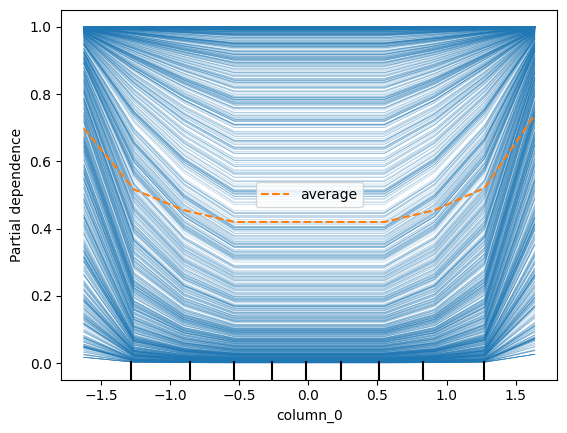

In [7]:
# mit PDP aus Paket:
features = ['column_0']
grid_resolution = 10 # Anzahl Ausprägungen für Feature
x_num=PartialDependenceDisplay.from_estimator(clf, X, features, kind='both', method='brute',
                                              grid_resolution=grid_resolution)

In [8]:
print(x_num.pd_results[0])
#print(x_num.lines_[0][0][0].get_data())

{'average': array([[0.69775399, 0.51653271, 0.45469451, 0.41980572, 0.41980572,
        0.41980572, 0.41980572, 0.45468667, 0.52084759, 0.73778727]]), 'individual': array([[[0.9983247 , 0.98946158, 0.97993317, ..., 0.97993151,
         0.98991739, 0.99890308],
        [0.23127816, 0.0452579 , 0.02406164, ..., 0.02405965,
         0.04722806, 0.31495788],
        [0.99836689, 0.98972465, 0.9804294 , ..., 0.98042777,
         0.9901692 , 0.99893072],
        ...,
        [0.18632824, 0.03482402, 0.01842012, ..., 0.01841859,
         0.03635727, 0.25922884],
        [0.92358666, 0.65569129, 0.49760871, ..., 0.49758751,
         0.66570618, 0.94864021],
        [0.99704493, 0.98153641, 0.96509518, ..., 0.96509233,
         0.98232889, 0.99806429]]]), 'values': [array([-1.62497055, -1.26244753, -0.89992452, -0.5374015 , -0.17487849,
        0.18764453,  0.55016755,  0.91269056,  1.27521358,  1.63773659])]}


In [9]:
# 1. Schritt (Wahl des zu untersuchenden Features):
data=X.copy()
X_S = 'column_0' # Feature

# 2. Schritt (Berechnung eines Grids (beinhaltet mögliche Werte für das gewähle Feature) auf Basis der
# 5%- und 95%-Quantile):
grid_resolution = 10 # Parameter für Gitter (Einträge im Gitter)
array_for_percentile = [0.05, 0.95] 

# berechnet Quantile auf Basis der Daten zum Feature X_S und den gegebenen Niveaus:
p = mquantiles(X[X_S], prob=array_for_percentile)

grid = [p.min() + i/(grid_resolution-1)*( p.max() - p.min() )
        for i in range(0, grid_resolution)]

print("5%-Quantil: ", p[0])
print("95%-Quantil: ", p[1])
print('Einträge im Gitter: ', len(grid))

# Abgleich gewählter Werte mit Paket:
grid_i = 5
data[X_S] = grid[grid_i] # Überschreiben des Wertes
y_pred = clf.predict_proba(data) # Predictions (WICHTIG: Predictionfunktion ist hier 'predict_proba')
y_pred = np.array([val[1] for val in y_pred])
print('Mittelwert (selbst berechnet) : ', np.mean(y_pred))
print('Mittelwert über Bibliothek    : ', x_num.pd_results[0]['average'][0][grid_i])

5%-Quantil:  -1.6249705477983925
95%-Quantil:  1.6377365934566899
Einträge im Gitter:  10
Mittelwert (selbst berechnet) :  0.41980572001004657
Mittelwert über Bibliothek    :  0.41980572001004846


In [10]:
# kompletter Abgleich über volles Grid:
columns_result = [X_S + '_grid(i)=' + str(grid_nr) for grid_nr in range(1, grid_resolution + 1)]
output_df = pd.DataFrame(columns=columns_result) # initialize dataframe for ice output (n rows, m columns)

for val in range(1, grid_resolution + 1):
    data=X.copy()
    data[X_S] = grid[val-1] # Überschreiben des Wertes
    y_pred = clf.predict_proba(data) # Predictions
    y_pred = np.array([val[1] for val in y_pred])
    col = X_S + '_grid(i)=' + str(val)
    output_df[col] = y_pred

# ABgleich PDP values:
pdp_values = output_df.mean().values
    
print('MSE: ', mse(pdp_values, x_num.pd_results[0]['average'][0]))
print('MAE: ', mae(pdp_values, x_num.pd_results[0]['average'][0]))

# Abgleich ICE values::
values_bibliothek = x_num.pd_results[0]['individual'][0]
values_selbst = output_df.values
value =  mae(values_bibliothek, values_selbst)

txt = "Betragsgrößter Abstand zwischen allen Werten: {:e}"
print(txt.format(value))

MSE:  2.194327541437041e-30
MAE:  1.3378187446733137e-15
Betragsgrößter Abstand zwischen allen Werten: 0.000000e+00


**Funktionsweise von 'PartialDependenceDisplay' für numerische Variable**

Im Prinzip funktioniert die Methode 'PartialDependenceDisplay' für numerische Variablen wie für kategoriale Variablen. Um nicht alle verschiedenen Ausprägungen aus dem Datensatz zum Feature X_S durchlaufen zu müssen (Dies wäre rechenintensiv!) wird aus dem 5% und 95%-Quantil der Daten zum Feature X_S ein äquidistantes Gitter mit  grid_resolution >= 2 Einträgen erzeugt. Das sind die Werte, die das zu untersuchende Feature in jedem Datensatz durchläuft. Anhand dieser Datensätze wird wieder die Predictionfunktion aufgerufen (ACHTUNG: Für ein Klassifikationsproblem wird hier 'predict_proba' verwendet) und über die Outputs für den PDP gemittelt. 